In [17]:
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# Load embeddings (col 0 = length, cols 1-384 = embeddings)
data = np.load('Data/all_embeddings.npy')
lengths = data[:, 0]
embeddings = data[:, 1:]
print(f'Loaded {embeddings.shape[0]} embeddings with {embeddings.shape[1]} dimensions')
print(f'Length range: {lengths.min():.0f} - {lengths.max():.0f}')

# Load embedding IDs
embedding_ids = np.loadtxt('Data/all_ids.txt', dtype = str)
print(f'Loaded {embedding_ids.shape[0]} embedding IDs')

# Load k-mer frequencies (col 0 = length, cols 1-2772 = k-mers)
kmers = np.load('Data/all_kmers.npy')
print(f'Loaded k-mer data: {kmers.shape}')

# Extract k-mer frequencies by size (new format without 7-mers)
six_mers = kmers[:, 1:2081]        # 2080 features
five_mers = kmers[:, 2081:2593]    # 512 features
four_mers = kmers[:, 2593:2729]    # 136 features
three_mers = kmers[:, 2729:2761]   # 32 features
two_mers = kmers[:, 2761:2771]     # 10 features
one_mers = kmers[:, 2771:2773]     # 2 features

print(f'6-mers: {six_mers.shape[1]} features')
print(f'5-mers: {five_mers.shape[1]} features')
print(f'4-mers: {four_mers.shape[1]} features')
print(f'3-mers: {three_mers.shape[1]} features')
print(f'2-mers: {two_mers.shape[1]} features')
print(f'1-mers: {one_mers.shape[1]} features')

Loaded 4776770 embeddings with 384 dimensions
Length range: 5000 - 10208085
Loaded 4776770 embedding IDs
Loaded k-mer data: (4776770, 2773)
6-mers: 2080 features
5-mers: 512 features
4-mers: 136 features
3-mers: 32 features
2-mers: 10 features
1-mers: 2 features



Number of pairwise distances: 49,995,000
Distance range: 1.04 - 44.95
Mean: 20.19, Std: 5.15


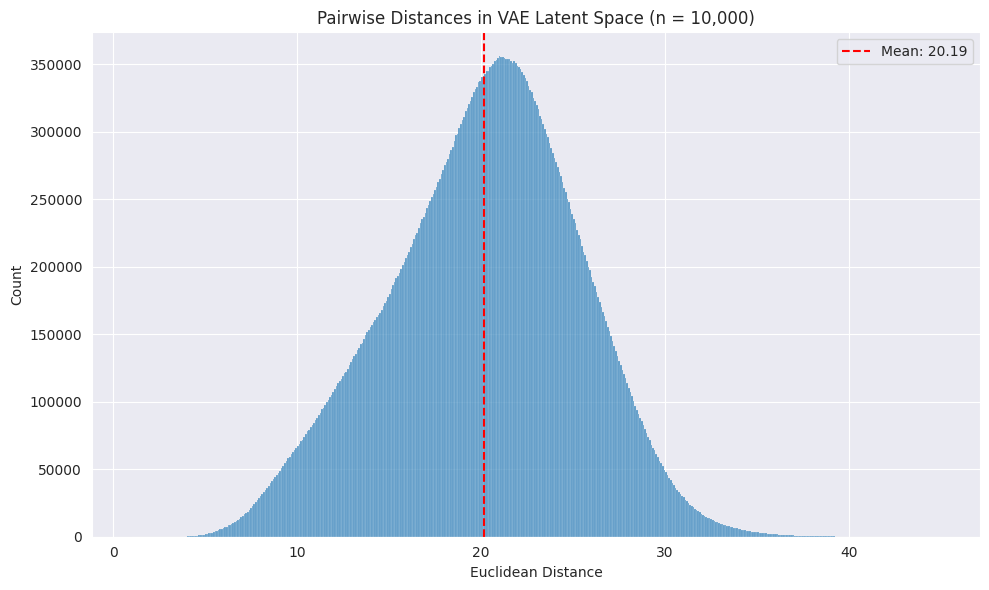

In [15]:
# Randomly sample 10,000 entries
rng = np.random.default_rng(42)
idx = rng.choice(len(embeddings), size = 10_000, replace = False)
sample = embeddings[idx]

# Calculate pairwise Euclidean distances
distances = pdist(sample, metric = 'euclidean')
print(f'\nNumber of pairwise distances: {len(distances):,}')
print(f'Distance range: {distances.min():.2f} - {distances.max():.2f}')
print(f'Mean: {distances.mean():.2f}, Std: {distances.std():.2f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Calculate pairwise cosine distances (using same sample)
cosine_distances = pdist(sample, metric = 'cosine')
print(f'Number of pairwise distances: {len(cosine_distances):,}')
print(f'Distance range: {cosine_distances.min():.4f} - {cosine_distances.max():.4f}')
print(f'Mean: {cosine_distances.mean():.4f}, Std: {cosine_distances.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(cosine_distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(cosine_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {cosine_distances.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Cosine Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()

Random sequence: index 3126737, ID SE_19_c_2529
Distances from random sequence to 4,776,769 others
Distance range: 0.4871 - 1.2345
Mean: 0.9989, Std: 0.0910


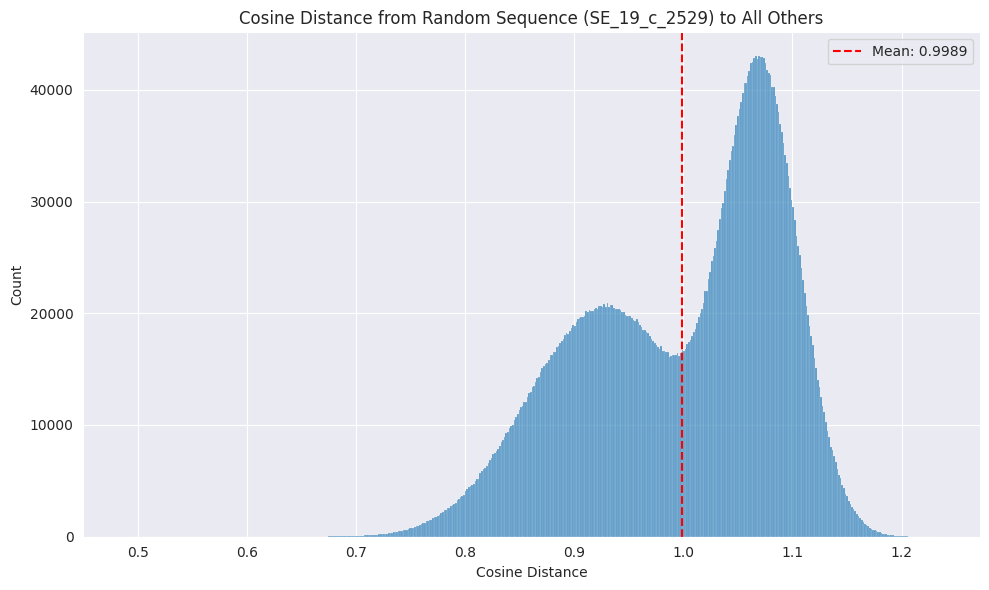

In [23]:
from scipy.spatial.distance import cdist

# Pick a random sequence
#rng = np.random.default_rng(42)
random_idx = rng.integers(len(embeddings))
random_id = embedding_ids[random_idx]
print(f'Random sequence: index {random_idx}, ID {random_id}')

# Calculate cosine distance from random sequence to all others
random_seq = embeddings[random_idx:random_idx + 1]  # Keep 2D shape
all_others = np.delete(embeddings, random_idx, axis = 0)

distances_from_random = cdist(random_seq, all_others, metric = 'cosine').flatten()
print(f'Distances from random sequence to {len(distances_from_random):,} others')
print(f'Distance range: {distances_from_random.min():.4f} - {distances_from_random.max():.4f}')
print(f'Mean: {distances_from_random.mean():.4f}, Std: {distances_from_random.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(distances_from_random, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(distances_from_random.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances_from_random.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title(f'Cosine Distance from Random Sequence ({random_id}) to All Others')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Filter to sequences within distance threshold
distance_threshold = 0.7
close_mask = distances_from_random < distance_threshold
close_distances = distances_from_random[close_mask]
print(f'Sequences within {distance_threshold} cosine distance: {len(close_distances):,}')

if len(close_distances) > 0:
    print(f'Distance range: {close_distances.min():.4f} - {close_distances.max():.4f}')
    print(f'Mean: {close_distances.mean():.4f}, Std: {close_distances.std():.4f}')

    # Plot histogram
    fig, ax = plt.subplots(figsize = (10, 6))
    sns.histplot(close_distances, bins = 50, alpha = 0.7, ax = ax)
    ax.axvline(close_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {close_distances.mean():.4f}')
    ax.set_xlabel('Cosine Distance')
    ax.set_ylabel('Count')
    ax.set_title(f'Cosine Distance from Random Sequence ({random_id}) - Close Neighbors Only (< {distance_threshold})')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f'No sequences found within {distance_threshold} cosine distance')

In [8]:
from scipy.spatial.distance import cdist

first_seq = embeddings[0:1]
distances = cdist(first_seq, embeddings[1:], metric = 'cosine').flatten()
closest_idx = distances.argmin() + 1  #+1 for skipping first
print(f'Closest to first: index {closest_idx} (distance: {distances.min():.4f})')

Closest to first: index 687621 (distance: 0.4554)


In [ ]:
# Extract 6-mer frequencies (columns 1 through 2080, after length column)
six_mer_freqs = kmers[:, 1:2081].flatten()
print(f'Total 6-mer frequency values: {len(six_mer_freqs):,}')
print(f'Range: {six_mer_freqs.min():.6f} - {six_mer_freqs.max():.6f}')
print(f'Mean: {six_mer_freqs.mean():.6f}, Std: {six_mer_freqs.std():.6f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(six_mer_freqs, bins = 500, alpha = 0.7, ax = ax, log_scale = (False, True))
ax.set_xlabel('6-mer Frequency')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of 6-mer Frequencies (n = {len(six_mer_freqs):,})')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze 6-mer frequency distribution
# How many 6-mers occur less than 1% of the time
threshold = 0.01
rare_counts = np.sum(six_mers < threshold, axis = 1)

print(f'6-mer rarity analysis (threshold: {threshold * 100:.0f}%)')
print(f'Total 6-mers per sequence: {six_mers.shape[1]}')
print(f'Rare 6-mers per sequence (< {threshold * 100:.0f}%):')
print(f'  Mean: {rare_counts.mean():.1f}')
print(f'  Min: {rare_counts.min()}')
print(f'  Max: {rare_counts.max()}')
print(f'  Median: {np.median(rare_counts):.0f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(rare_counts, bins = 100, alpha = 0.7, ax = ax)
ax.axvline(rare_counts.mean(), color = 'red', linestyle = '--', label = f'Mean: {rare_counts.mean():.1f}')
ax.set_xlabel(f'Number of 6-mers with frequency < {threshold * 100:.0f}%')
ax.set_ylabel('Count (sequences)')
ax.set_title(f'Distribution of Rare 6-mer Counts (n = {len(rare_counts):,})')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Sample 100,000 sequences and check for close neighbors
from scipy.spatial.distance import squareform

sample_size = 100_000
neighbor_threshold = 0.1

rng_sample = np.random.default_rng(123)
sample_idx = rng_sample.choice(len(embeddings), size = sample_size, replace = False)
sample_embeddings = embeddings[sample_idx]

# Compute pairwise cosine distances within sample
pairwise_cos = pdist(sample_embeddings, metric = 'cosine')
pairwise_matrix = squareform(pairwise_cos)

# For each sequence, check if it has any neighbor within threshold
# (set diagonal to inf to exclude self-distance)
np.fill_diagonal(pairwise_matrix, np.inf)
min_distances = pairwise_matrix.min(axis = 1)
has_close_neighbor = min_distances < neighbor_threshold

print(f'Sampled {sample_size:,} sequences')
print(f'Sequences with at least one neighbor within {neighbor_threshold} cosine distance: {has_close_neighbor.sum():,} ({100 * has_close_neighbor.mean():.2f}%)')
print(f'Minimum distance found: {min_distances.min():.4f}')
print(f'Mean nearest neighbor distance: {min_distances.mean():.4f}')

# Plot histogram of minimum distances (zoomed to 0.2)
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(min_distances[min_distances < 0.2], bins = 100, alpha = 0.7, ax = ax)
ax.axvline(neighbor_threshold, color = 'red', linestyle = '--', label = f'Threshold: {neighbor_threshold}')
ax.set_xlim(0, 0.2)
ax.set_xlabel('Nearest Neighbor Cosine Distance')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Nearest Neighbor Distances (n = {sample_size:,}, zoomed to < 0.2)')
ax.legend()
plt.tight_layout()
plt.show()